### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2 --max_classes_per_drift 0

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[i]) / (i + 1) for i in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
    return np.mean(cumulative_averages, axis=0)

In [4]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [5]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [ ]:
def plot_cumulative_subplots(accuracy_arrays, subtitles, plot_filename=""):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Relearning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 8}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

In [7]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

CIFAR100 10 Tasks, 10 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [17]:
er_500_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-21-18-05-seq-cifar100-er-buf-500-drift-6-n-4-adaptation-0.json"
)
# 9.66, 9.78, 9.87
# 9.769999999999998 ± 0.08602325267042588
# plot_results(
#     er_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_500_accuracy_array_without_drift)[1]

74.17777777777778

### With Permutation Drift in Tasks 3, 5, 7, 9

In [22]:
er_500_accuracy_array_with_drift = read_results(
    "./logs/01-21-25-23-24-50-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-0.json"
)
# 8.62, 8.70, 8.79
# 8.703333333333333 ± 0.0694422221866655
# plot_results(
#     er_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# )
average_forgetting(er_500_accuracy_array_with_drift)[1]

75.57777777777777

### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [10]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-00-09-31-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-1.json"
# )
# # 16.18, 16.31, 16.43
# # 16.306666666666665 ± 0.10208928554075702

3 files found
1: ./reimplementation-logs/02-24-25-15-49-18-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-16-36-02-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-15-03-02-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 13.706666666666665
Avg Forgetting: 66.88888888888889


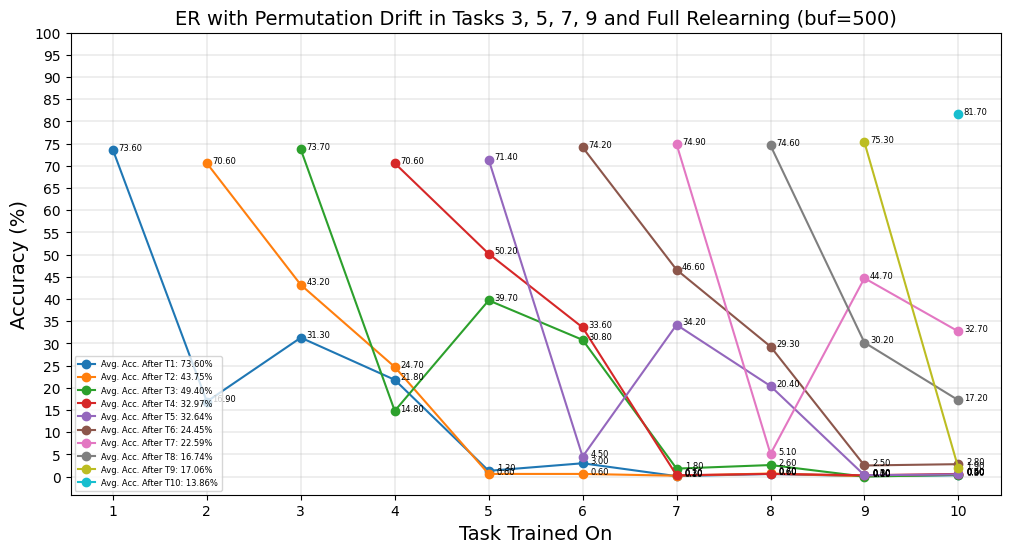

In [20]:
er_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-24-25-16-36-02-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)
# 13.31, 13.86, 13.95
plot_results(
    er_500_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [23]:
# before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-02-07-26-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-2.json"
# )
# # 11.67, 11.90, 12.37
# # 11.979999999999999 ± 0.29131884021921145

3 files found
1: ./reimplementation-logs/02-24-25-17-38-36-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-17-06-22-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-18-09-10-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 12.79
Avg Forgetting: 70.53333333333335


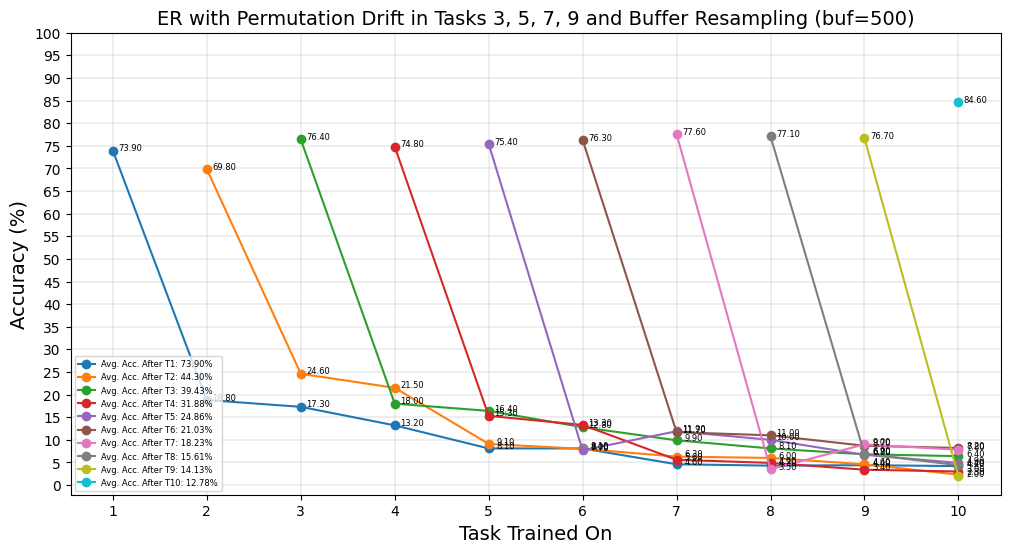

In [28]:
er_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-18-09-10-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)
# 12.47, 12.78, 13.12
plot_results(
    er_500_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

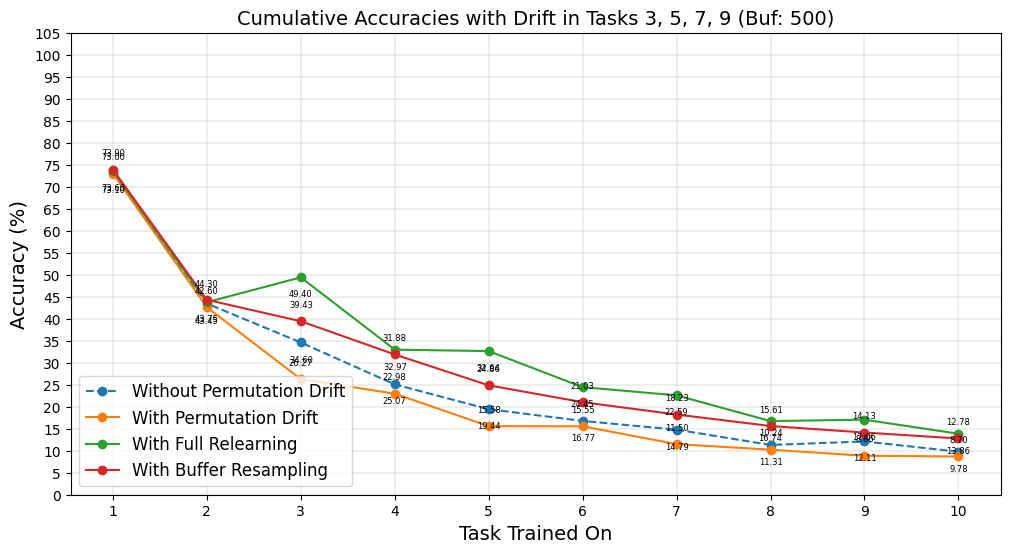

In [80]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [30]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-22-25-03-53-38-seq-cifar100-er-buf-5000-drift-6-n-4-adaptation-0.json"
)
# 22.44, 22.80, 23.39
# 22.876666666666665 ± 0.39160637833870293
# plot_results(
#     er_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_5000_accuracy_array_without_drift)[1]

56.51111111111111

### With Permutation Drift in Tasks 3, 5, 7, 9

In [31]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-05-12-56-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-0.json"
)
# 10.77, 11.01, 11.10
# 10.96 ± 0.13928388277184126
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# )
average_forgetting(er_5000_accuracy_array_with_drift)[1]

69.66666666666667

### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [32]:
# before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-06-26-42-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-1.json"
# )
# # 25.37, 25.40, 26.01
# # 25.593333333333334 ± 0.2948822740612871

3 files found
1: ./reimplementation-logs/02-24-25-16-50-49-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-15-09-05-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-16-00-22-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 22.046666666666667
Avg Forgetting: 54.13333333333334


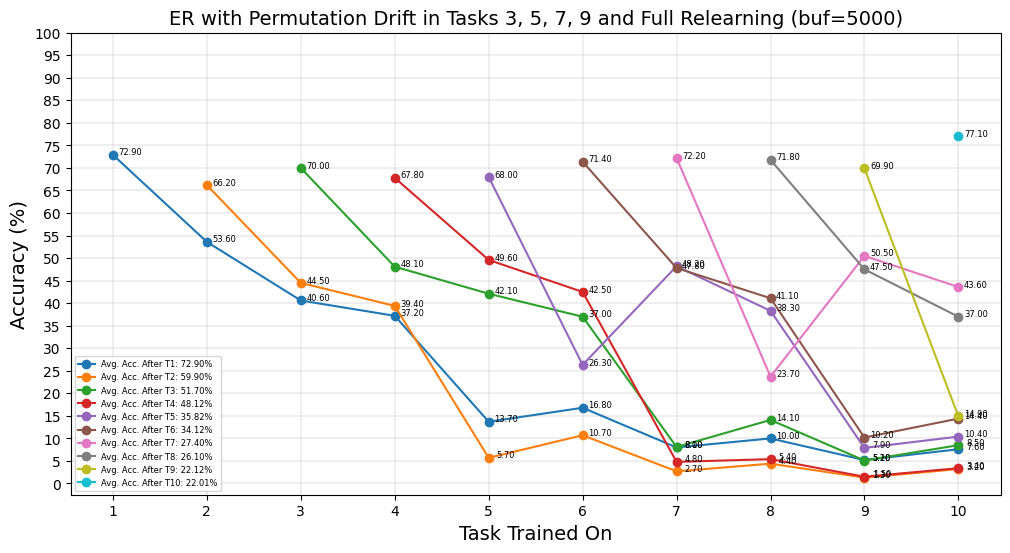

In [37]:
er_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-24-25-16-00-22-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)
# 21.75, 22.01, 22.38
plot_results(
    er_5000_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [ ]:
# before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-09-03-09-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-2.json"
# )
# # 23.72, 23.78, 23.82
# # 23.77333333333333 ± 0.041096093353127174

55.87777777777777

3 files found
1: ./reimplementation-logs/02-24-25-18-26-11-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-17-22-05-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-17-53-47-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 24.060000000000002
Avg Forgetting: 55.56666666666667


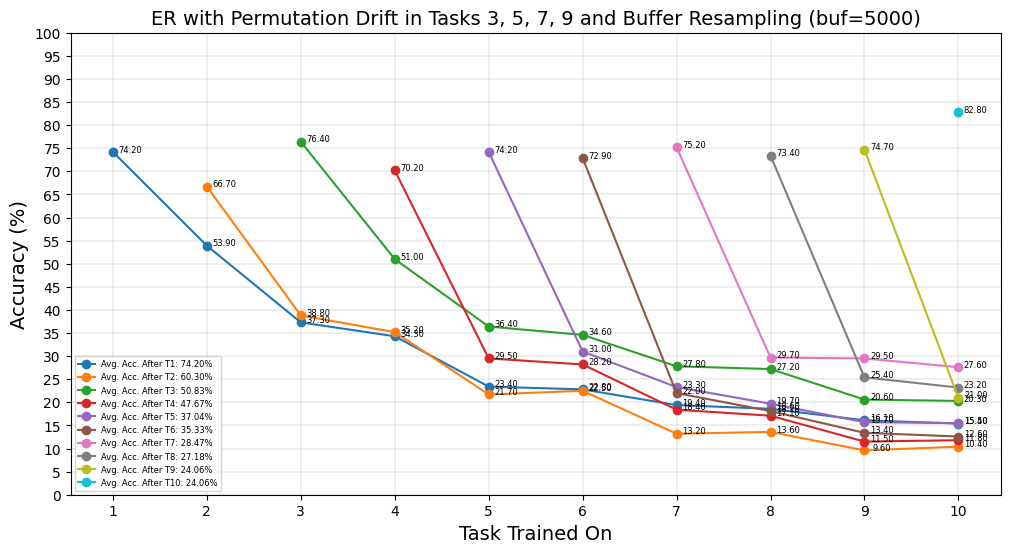

In [42]:
er_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-17-53-47-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)
# 23.71, 24.06, 24.41
plot_results(
    er_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

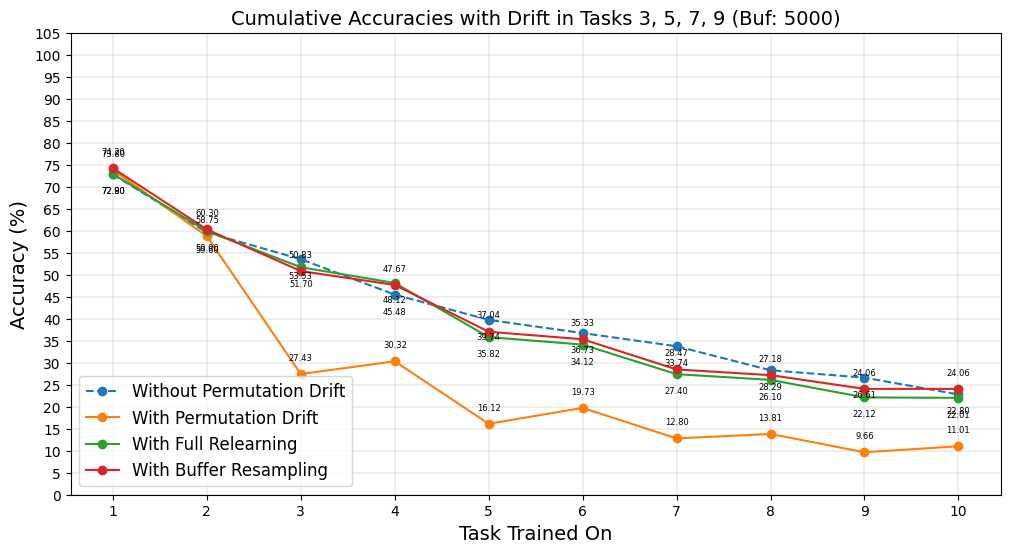

In [79]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [44]:
er_ace_500_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-23-30-03-seq-cifar100-er_ace-buf-500-drift-6-n-4-adaptation-0.json"
)
# 20.88, 21.82, 22.67
# 21.790000000000003 ± 0.7310722718491437
# plot_results(
#     er_ace_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

38.099999999999994

### With Permutation Drift in Tasks 3, 5, 7, 9

In [45]:
er_ace_500_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-00-12-08-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-0.json"
)
# 6.76, 6.86, 7.54
# 7.053333333333334 ± 0.3465384378231207
# plot_results(
#     er_ace_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# )
average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

55.044444444444444

### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [46]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-05-18-59-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-1.json"
# )
# # 17.43, 17.62, 17.95
# # 17.666666666666668 ± 0.21483844059095994

3 files found
1: ./reimplementation-logs/02-24-25-16-52-53-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-18-09-08-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-15-32-34-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 16.236666666666668
Avg Forgetting: 49.18888888888889


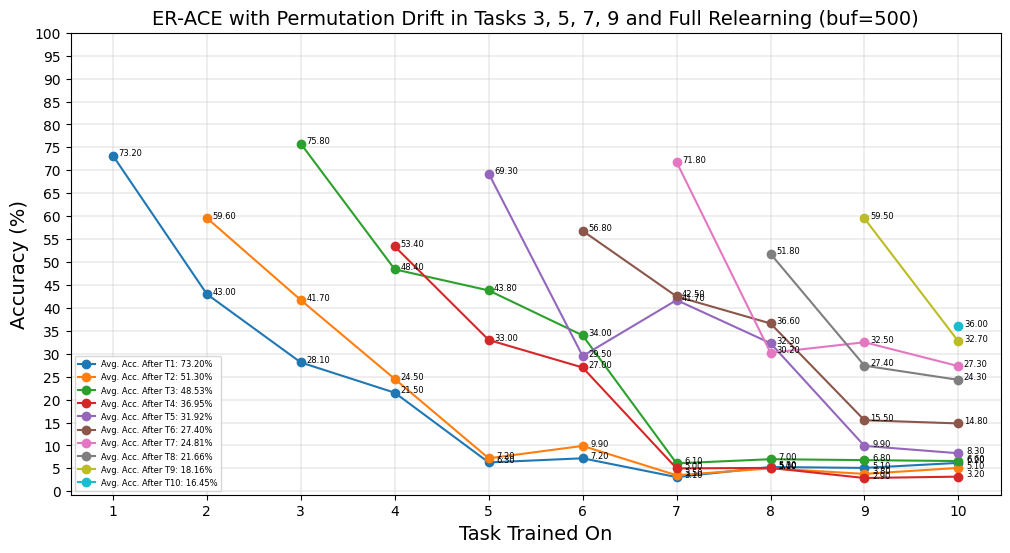

In [53]:
er_ace_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-24-25-16-52-53-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)
# 15.60, 16.45, 16.66
plot_results(
    er_ace_500_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [54]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-07-36-40-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-2.json"
# )
# # 11.44, 12.29,  12.30
# # 12.01 ± 0.4030715403829286

3 files found
1: ./reimplementation-logs/02-24-25-19-59-38-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-20-56-17-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-19-03-32-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 11.873333333333335
Avg Forgetting: 51.56666666666667


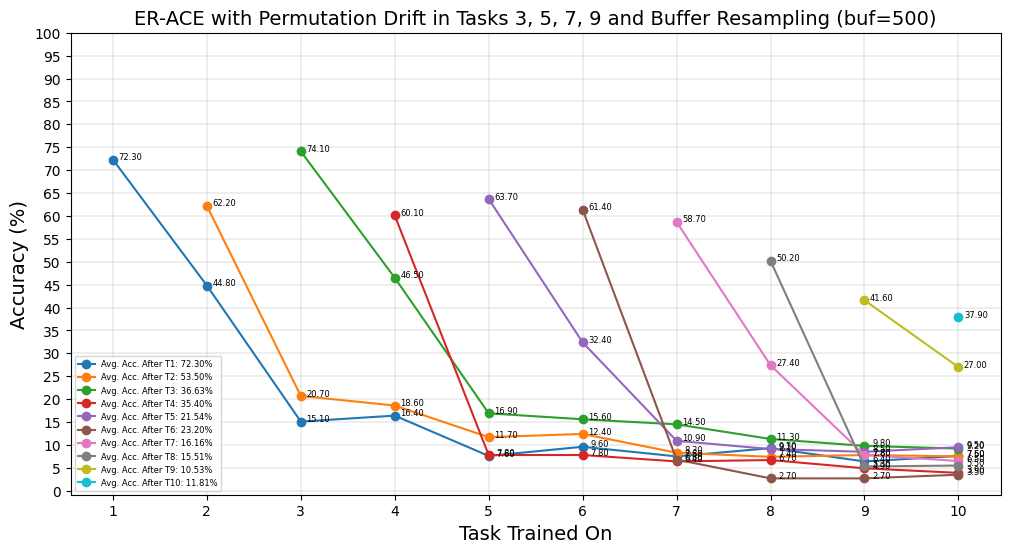

In [59]:
er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-19-59-38-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)
# 11.81, 11.81, 12.00
plot_results(
    er_ace_500_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=500)",
)
print(
    f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_buffer_resampling)[1]}"
)

### Cumulative Plots

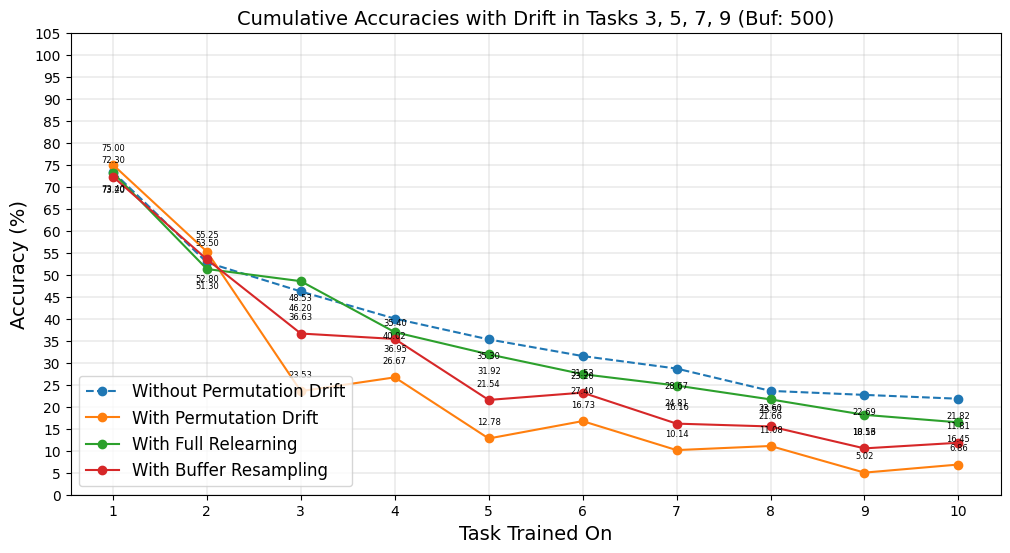

In [77]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [61]:
er_ace_5000_accuracy_array_without_drift = read_results(
    "./logs/01-22-25-09-04-50-seq-cifar100-er_ace-buf-5000-drift-6-n-4-adaptation-0.json"
)
# 31.88, 32.03, 32.40
# 32.10333333333333 ± 0.21853044537444974
# plot_results(
#     er_ace_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

31.833333333333332

### With Permutation Drift in Tasks 3, 5, 7, 9

In [62]:
er_ace_5000_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-11-27-54-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-0.json"
)
# 9.66, 9.75, 9.99
# 9.799999999999999 ± 0.13928388277184126
# plot_results(
#     er_ace_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# )
average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

56.52222222222222

### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [63]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-13-31-06-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-1.json"
# )
# # 25.24, 25.80, 25.89
# # 25.643333333333334 ± 0.28755675768253036

3 files found
1: ./reimplementation-logs/02-24-25-18-36-47-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-17-08-53-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-15-40-16-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 23.333333333333332
Avg Forgetting: 44.96666666666666


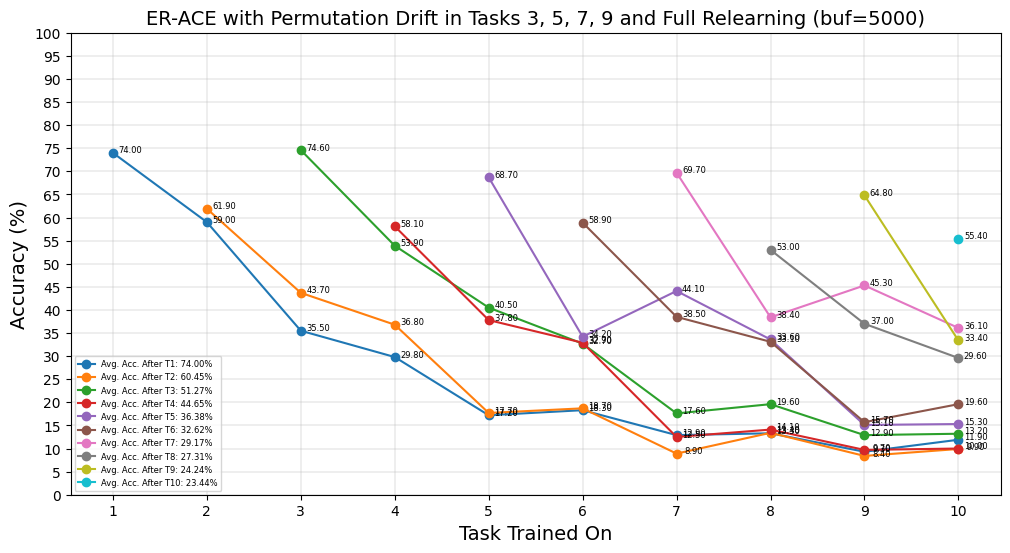

In [68]:
er_ace_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-24-25-17-08-53-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)
# 22.68, 23.44, 23.88
plot_results(
    er_ace_5000_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [69]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-18-33-45-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-2.json"
# )
# # 21.94, 22.48, 22.78
# # 22.400000000000002 ± 0.3475629439396552

3 files found
1: ./reimplementation-logs/02-24-25-20-28-30-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-19-33-42-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-21-26-39-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 22.923333333333336
Avg Forgetting: 46.37777777777778


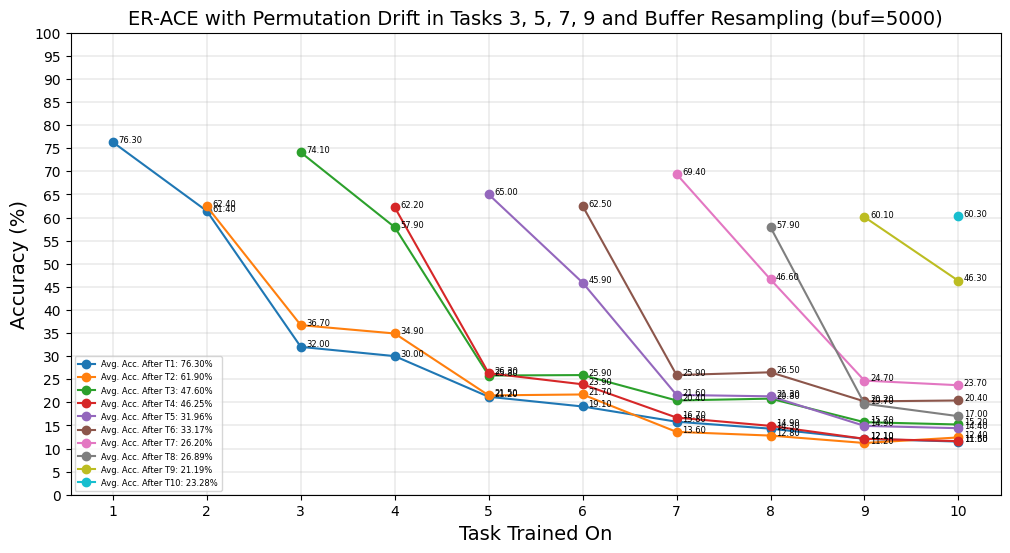

In [74]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-20-28-30-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)
# 22.11, 23.28, 23.38
plot_results(
    er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

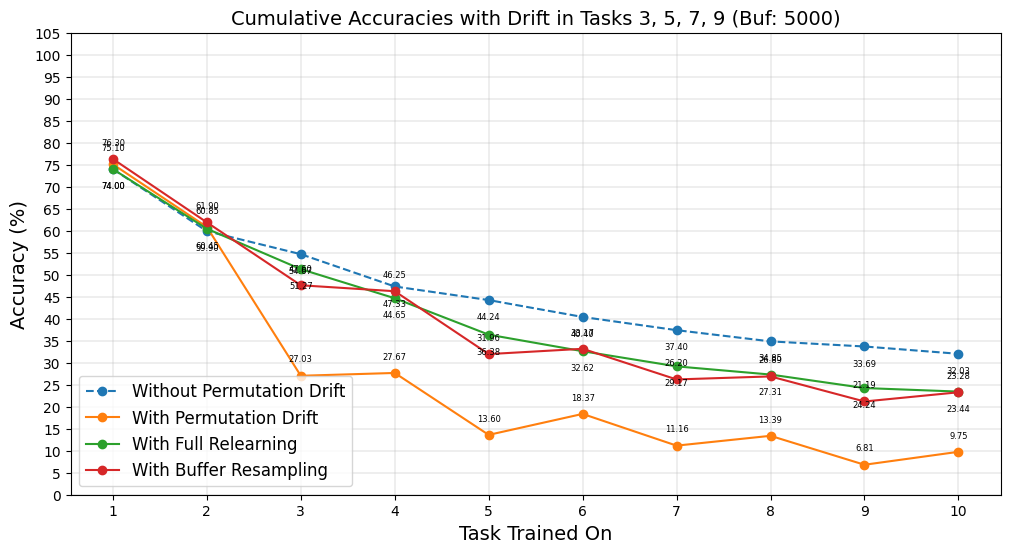

In [78]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [81]:
derpp_500_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-22-50-54-seq-cifar100-derpp-buf-500-drift-6-n-4-adaptation-0.json"
)
# 11.67, 11.76, 11.99
# 11.806666666666667 ± 0.13474255287605172
# plot_results(
#     derpp_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(derpp_500_accuracy_array_without_drift)[1]

70.4

### With Permutation Drift in Tasks 3, 5, 7, 9

In [82]:
derpp_500_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-02-32-43-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-0.json"
)
# 8.85, 8.90, 8.94
# 8.896666666666667 ± 0.036817870057290834
# plot_results(
#     derpp_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# )
average_forgetting(derpp_500_accuracy_array_with_drift)[1]

74.33333333333333

### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [83]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-06-54-49-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-1.json"
# )
# # 17.05, 17.05, 17.46
# # 17.186666666666667 ± 0.19327585352432305

3 files found
1: ./reimplementation-logs/02-24-25-18-17-42-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-16-18-27-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-20-21-28-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 16.080000000000002
Avg Forgetting: 63.12222222222223


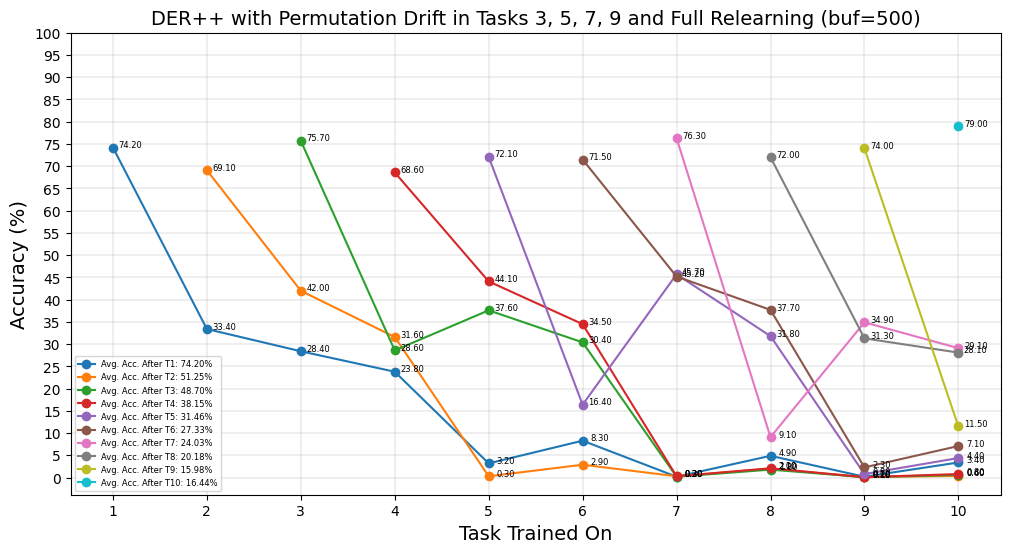

In [88]:
derpp_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-24-25-18-17-42-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)
# 15.30, 16.44, 16.50
plot_results(
    derpp_500_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [89]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-14-40-25-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-2.json"
# )
# # 11.42, 11.75, 11.85
# # 11.673333333333334 ± 0.18372685039360884

3 files found
1: ./reimplementation-logs/02-24-25-21-44-08-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-25-25-00-30-05-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-23-06-51-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 12.016666666666667
Avg Forgetting: 69.3


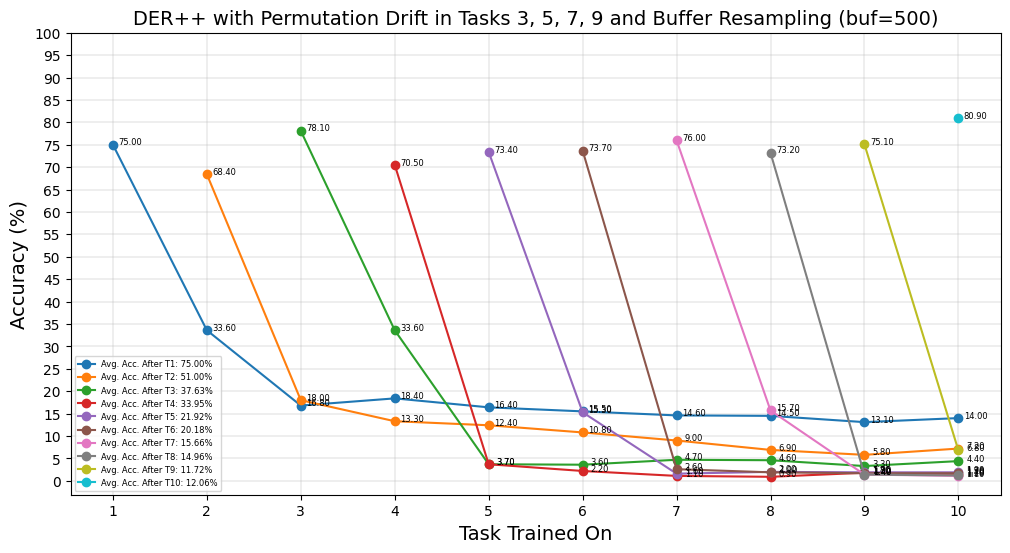

In [94]:
derpp_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-21-44-08-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)
# 11.78, 12.06, 12.21
plot_results(
    derpp_500_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

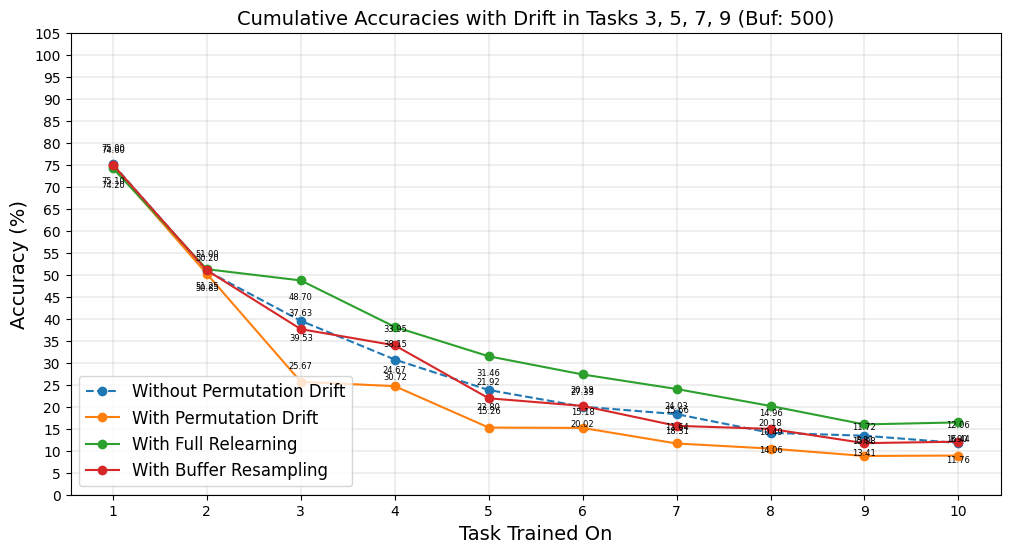

In [111]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [96]:
derpp_5000_accuracy_array_without_drift = read_results(
    "./logs/01-22-25-15-56-23-seq-cifar100-derpp-buf-5000-drift-6-n-4-adaptation-0.json"
)
# 30.63, 31.30, 32.41
# 31.44666666666667 ± 0.734045109119474
# plot_results(
#     derpp_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

35.577777777777776

### With Permutation Drift in Tasks 3, 5, 7, 9

In [97]:
derpp_5000_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-21-31-28-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-0.json"
)
# 10.35, 10.39, 10.54
# 10.426666666666668 ± 0.08178562764256828
# plot_results(
#     derpp_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# )
average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

58.866666666666674

### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [98]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-01-50-31-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-1.json"
# )
# # 27.79, 27.87, 28.44
# # 28.03333333333333 ± 0.28940552094864386

3 files found
1: ./reimplementation-logs/02-24-25-21-05-05-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-16-33-59-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-18-43-43-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 24.413333333333338
Avg Forgetting: 43.38888888888889


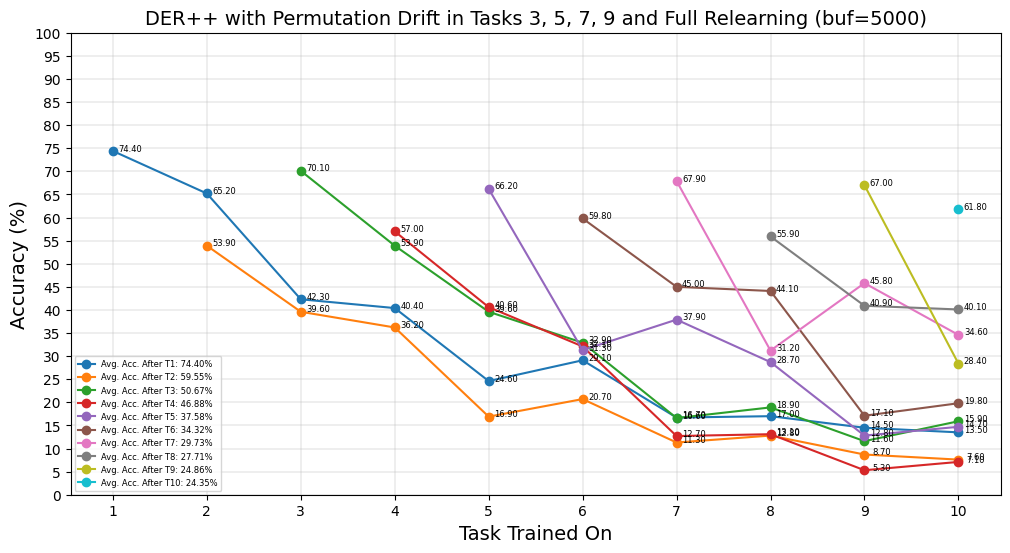

In [ ]:
derpp_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-24-25-18-43-43-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)
# 24.32, 24.35, 24.57
plot_results(
    derpp_5000_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [103]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-07-52-45-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-2.json"
# )
# # 21.85, 22.32, 22.53
# # 22.233333333333334 ± 0.2842924941362717

3 files found
1: ./reimplementation-logs/02-24-25-23-50-38-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-25-25-01-16-20-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-22-26-58-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 22.683333333333334
Avg Forgetting: 54.67777777777778


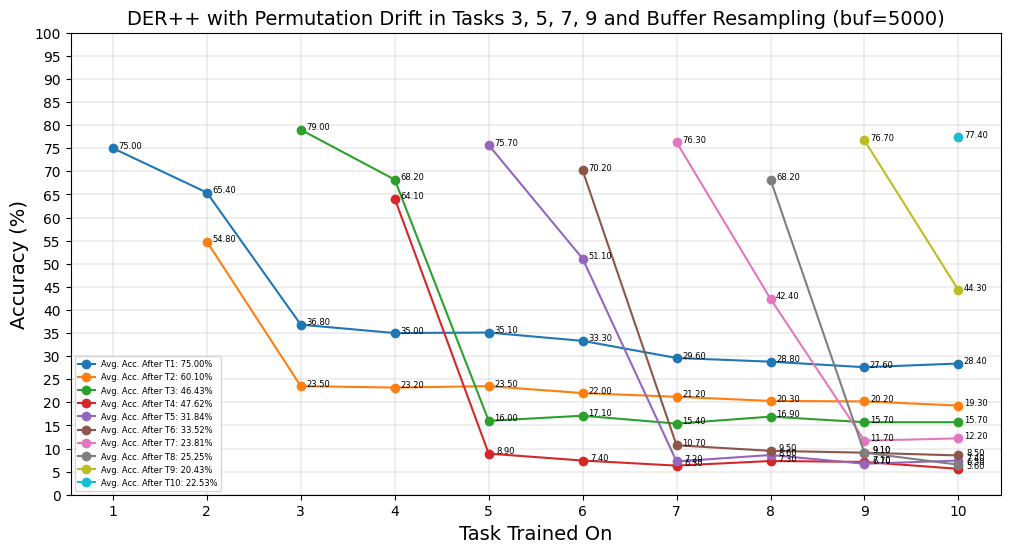

In [108]:
derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-23-50-38-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)
# 22.46, 22.53, 23.06
plot_results(
    derpp_5000_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

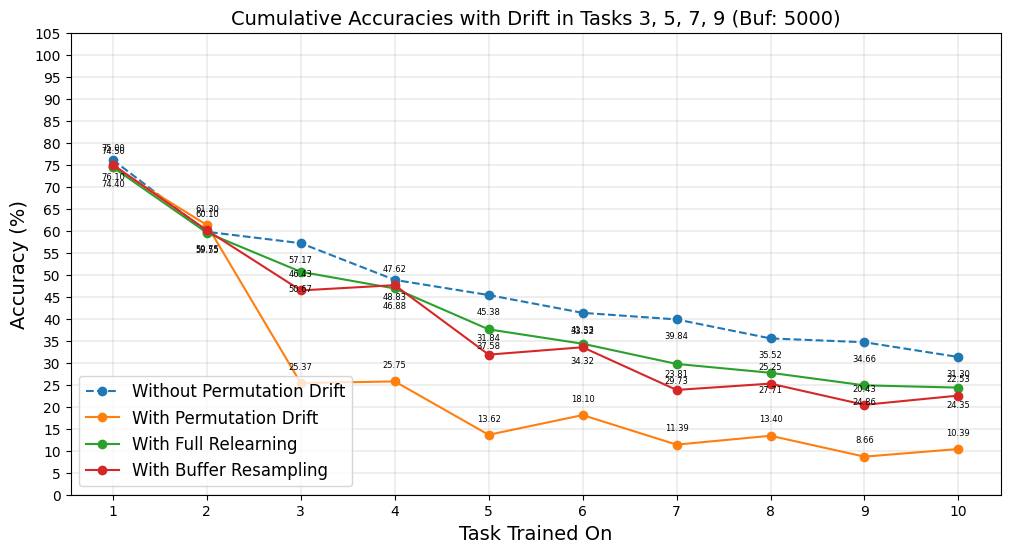

In [110]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# Comparisons

## Buffer 500

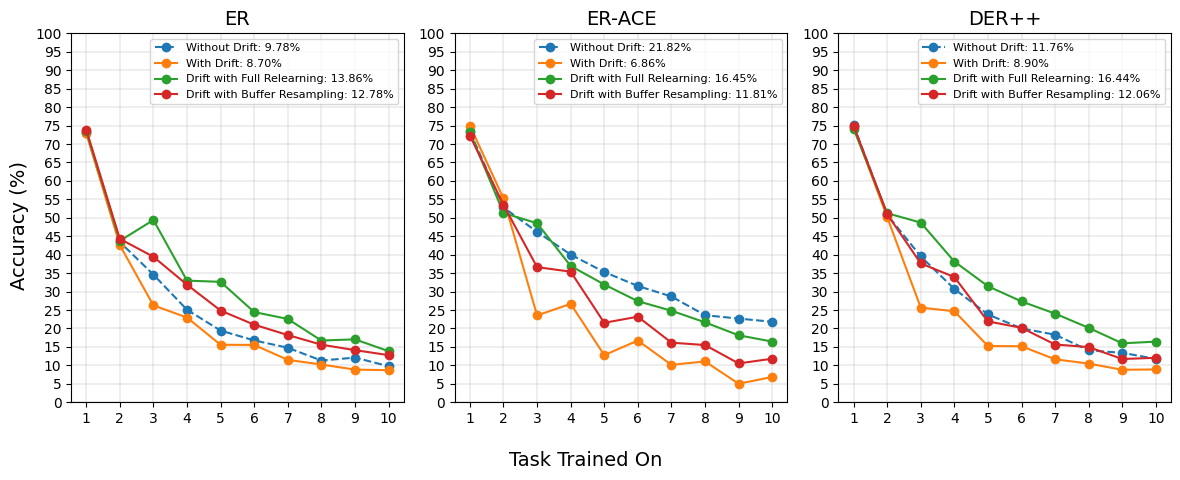

In [117]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR100_Buff_500_n_4.pdf",
)

## Buffer 5000

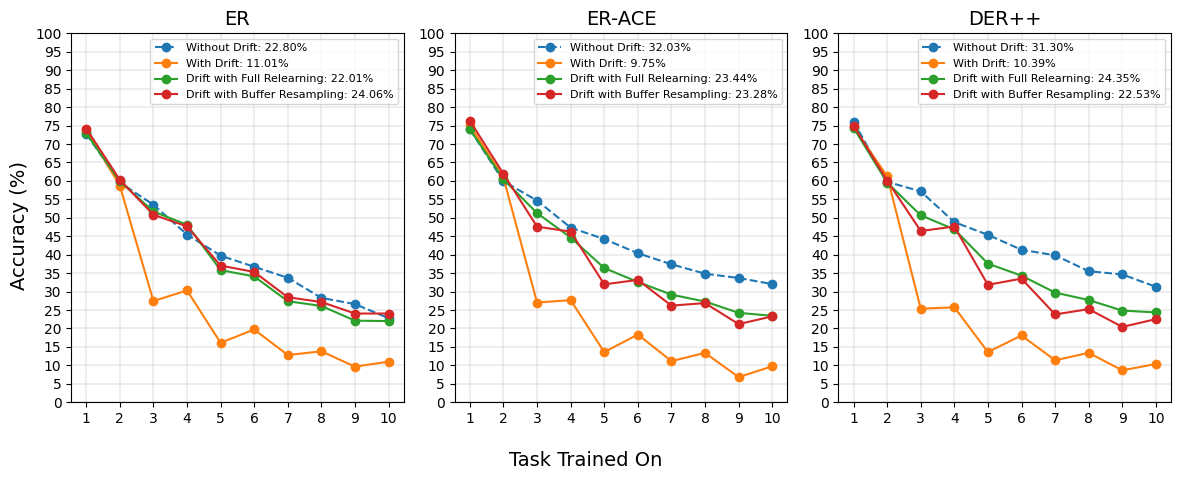

In [118]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR100_Buff_5000_n_4.pdf",
)